<a href="https://colab.research.google.com/github/mehmetdamkaci/Monophonic_Pitch_Detection/blob/main/NSynth_pitchDetection_cqt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-valid.jsonwav.tar.gz

--2023-04-16 20:25:50--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 142.251.16.128, 2607:f8b0:4004:c17::80
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|142.251.16.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M   125MB/s    in 2.7s    

2023-04-16 20:25:53 (125 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]

--2023-04-16 20:25:53--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-valid.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 142.251.16.128, 2607:f8b0:4004:c17::80
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|142.251.16.128|:80... connected.
HTTP request sent, 

In [ ]:
!gunzip < nsynth-test.jsonwav.tar.gz | tar xvf -
!gunzip < nsynth-valid.jsonwav.tar.gz | tar xvf -

In [ ]:
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-train.jsonwav.tar.gz

--2023-05-08 07:36:33--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-train.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 74.125.196.128, 2607:f8b0:400c:c36::80
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|74.125.196.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23815298079 (22G) [application/gzip]
Saving to: ‘nsynth-train.jsonwav.tar.gz’

nsynth-train.jsonwa 100%[===================>]  22.18G   114MB/s    in 4m 2s   

2023-05-08 07:40:36 (93.9 MB/s) - ‘nsynth-train.jsonwav.tar.gz’ saved [23815298079/23815298079]



In [ ]:
!tar -xzvf nsynth-train.jsonwav.tar.gz && rm nsynth-train.jsonwav.tar.gz

In [ ]:
import pandas as pd 
import json
import librosa
from tqdm import tqdm
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import random
from google.colab import drive

drive.mount('/content/gdrive')
pitchIDSelect=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/pitcID_71Class.npy')

numClass=len(pitchIDSelect)
numOfColumn=83
numOfRow=90

# .json uzantılı dosyayı pandas dataframe'ine dönüştürür.
def jsonTOcsv(path):

  with open(path,'r') as f:
    data = json.loads(f.read())
  dataFrame=pd.DataFrame(data.values(),index=data.keys())

  return dataFrame

# .wav uzantılı dosyaları okur.
def readWav(frame, path):

  sortTimePath=list()
  timeList=list()
  megaDataList=list()

  for wavPath in tqdm(frame.index, desc='Data Reading'):
    wavData, sampleRate=librosa.load(path+wavPath+'.wav', sr=16000)
    megaDataList.append(wavData)
    time=len(wavData)/sampleRate
    timeList.append(time)
    if time<1.3152:
      sortTimePath.append(wavPath)
    
  print(f'\nMinumum Time : {min(timeList):.5f} \n')

  return megaDataList, sortTimePath

# one hot encoding işlemini yapar.
numClass=len(pitchIDSelect)
def oneHotEnc(number):
  label=np.zeros((numClass), dtype=np.uint8)
  label[number-min(pitchIDSelect)]=1
  return label

def setData(Data, Label, pathList, pitchIDList, filePath):
  pbar=tqdm(total=len(pathList))
  for index, (path, note) in enumerate(zip(pathList,pitchIDList)):
    data=librosa.load(filePath+path+'.wav', sr=16000)[0]
    cqtWav=librosa.cqt(data, sr=16000, n_bins=90, hop_length=256)
    Data[index]=np.log10(np.abs(cqtWav[:,:numOfColumn])+1e-16)
    Label[index]=oneHotEnc(note)  
    pbar.update(1)
  pbar.close()
  return Data, Label

# verilerin son 6 sütununun sıfır olup olmadığını kontrol eder.
def dataControl(dataset):
  delList=list()
  for i in tqdm(range(len(dataset)), desc='Data Checking'):
    a=0
    for j in range(numOfRow):
      for k in range(6):
        if dataset[i][:,numOfColumn-6:][j][k]==-16.0 :
          pass
        else:
          a+=1
    if a==0:
      delList.append(i)
  return delList

# Verileri görselleştirir.
def drawSpec(data, label):

  plt.figure(figsize=(25,10))
  for i in range(8):
    index=random.randint(0,len(data))
    plt.subplot(2, 4, i+1)
    librosa.display.specshow(data[index].reshape(numOfRow,numOfColumn), sr=16000, 
                             hop_length=2048//4, x_axis='s', y_axis='hz', cmap='viridis')
    plt.title(np.where(label[index]==1)[0][0])
  plt.show()

Mounted at /content/gdrive


#Train Datası ile Test

In [ ]:
trainFrame=jsonTOcsv('/content/nsynth-train/examples.json')
trainFrame=trainFrame.loc[trainFrame['pitch'].isin(pitchIDSelect)]

In [ ]:
import tensorflow as tf

class CustomAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,  activation=None):
        super(CustomAttentionLayer, self).__init__()
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):

        self.input_dim = input_shape[-1]
        self.w = self.add_weight(
            shape=(self.input_dim,1),
            initializer="random_normal",
            trainable=True,
        )
        

    def call(self, inputs):        
        
        alphaVector = tf.reshape(self.activation(self.w), shape=[32,])
        # attentionVector = tf.keras.layers.Softmax(axis=0)(alphaVector)
        
        #output = inputs*attentionVector
        
        return alphaVector

input_tensor = tf.keras.layers.Input(shape=(7,6,32), batch_size=None)
layer = CustomAttentionLayer(activation='tanh')(input_tensor)
layer.shape

TensorShape([32])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, Resizing, BatchNormalization, Activation, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

def buildModel(inputAudio):

  layer1 = Conv2D(32, 3, activation='relu')(inputAudio)  
  layerb = BatchNormalization()(layer1)
  layer2 = MaxPooling2D()(layerb)
  layerd = Dropout(0.25)(layer2)
  layer3 = Conv2D(32, 3, activation='relu')(layerd)  
  layer4 = MaxPooling2D()(layer3)
  layerd1 = Dropout(0.25)(layer4)
  layer5 = Conv2D(32, 3, activation='relu')(layerd1)
  layer6 = MaxPooling2D()(layer5)  
  layerd2 = Dropout(0.25)(layer6)
  layer7 = Conv2D(32, 3, activation='relu')(layerd2)

  alphaLayer = CustomAttentionLayer(activation='tanh')(layer7)
  attentionLayer = tf.keras.layers.Softmax()(alphaLayer)
  multiplyLayer = layer7*attentionLayer

  #layer8 = MaxPooling2D()(layer7)  
  layer9 = Dropout(0.25)(multiplyLayer) 
  layer10 = Flatten()(layer9)
  layer11 = Dense(512, activation='relu')(layer10)
  layerd3 = Dropout(0.25)(layer11)  
  layer13 = Dense(128, activation='relu')(layerd3)   
  layerd4 = Dropout(0.25)(layer13)  
  layer14 = Dense(71, activation='softmax')(layerd4) 

  return layer14

numOfRow=90
numOfColumn=83
inputSignal = Input(shape=(numOfRow, numOfColumn, 1))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 90, 83, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 88, 81, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 88, 81, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 44, 40, 32)   0           ['batch_normalization[0][0]']

In [ ]:
filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_cqt_attention_2.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resultList=list()
for i in range(30):  
  frame=trainFrame[i*int(len(trainFrame)/30):(i+1)*int(len(trainFrame)/30)]
  path=frame.index
  pitchIDList=frame['pitch']
  trainData=np.zeros((len(path), numOfRow, numOfColumn), dtype=np.float32)
  trainLabel=np.zeros((len(path),numClass), dtype=np.uint8)
  trainData, trainLabel=setData(trainData, trainLabel, path, pitchIDList, '/content/nsynth-train/audio/')
  test_dataset = tf.data.Dataset.from_tensor_slices((trainData, trainLabel))
  test_dataset = test_dataset.batch(32)
  result = predModel.evaluate(test_dataset)[1]
  resultList.append(result)

100%|██████████| 8288/8288 [09:52<00:00, 13.98it/s]


259/259 [==============================] - 25s 87ms/step - loss: 1.1453 - accuracy: 0.8902


100%|██████████| 8288/8288 [09:34<00:00, 14.42it/s]


259/259 [==============================] - 23s 88ms/step - loss: 1.1387 - accuracy: 0.8875


100%|██████████| 8288/8288 [09:45<00:00, 14.15it/s]


259/259 [==============================] - 23s 88ms/step - loss: 1.1258 - accuracy: 0.8907


100%|██████████| 8288/8288 [09:45<00:00, 14.16it/s]


259/259 [==============================] - 28s 105ms/step - loss: 1.1446 - accuracy: 0.8871


100%|██████████| 8288/8288 [09:46<00:00, 14.13it/s]


259/259 [==============================] - 32s 123ms/step - loss: 1.2232 - accuracy: 0.8845


100%|██████████| 8288/8288 [10:05<00:00, 13.69it/s]


259/259 [==============================] - 26s 99ms/step - loss: 1.1533 - accuracy: 0.8906


100%|██████████| 8288/8288 [09:54<00:00, 13.94it/s]


259/259 [==============================] - 27s 101ms/step - loss: 1.1952 - accuracy: 0.8793


100%|██████████| 8288/8288 [09:50<00:00, 14.04it/s]


259/259 [==============================] - 27s 101ms/step - loss: 1.2859 - accuracy: 0.8786


100%|██████████| 8288/8288 [09:49<00:00, 14.06it/s]


259/259 [==============================] - 26s 99ms/step - loss: 1.2190 - accuracy: 0.8816


100%|██████████| 8288/8288 [09:39<00:00, 14.31it/s]


259/259 [==============================] - 23s 86ms/step - loss: 1.1704 - accuracy: 0.8866


100%|██████████| 8288/8288 [09:47<00:00, 14.10it/s]


259/259 [==============================] - 24s 91ms/step - loss: 1.1129 - accuracy: 0.8851


100%|██████████| 8288/8288 [09:45<00:00, 14.15it/s]


259/259 [==============================] - 24s 93ms/step - loss: 1.3120 - accuracy: 0.8787


100%|██████████| 8288/8288 [09:48<00:00, 14.08it/s]


259/259 [==============================] - 25s 95ms/step - loss: 1.0914 - accuracy: 0.8894


100%|██████████| 8288/8288 [09:49<00:00, 14.06it/s]


259/259 [==============================] - 23s 87ms/step - loss: 1.1809 - accuracy: 0.8867


100%|██████████| 8288/8288 [09:54<00:00, 13.95it/s]


259/259 [==============================] - 26s 99ms/step - loss: 1.2344 - accuracy: 0.8814


100%|██████████| 8288/8288 [10:10<00:00, 13.58it/s]


259/259 [==============================] - 24s 91ms/step - loss: 1.1513 - accuracy: 0.8847


100%|██████████| 8288/8288 [09:42<00:00, 14.22it/s]


259/259 [==============================] - 23s 88ms/step - loss: 1.1747 - accuracy: 0.8861


100%|██████████| 8288/8288 [09:33<00:00, 14.45it/s]


259/259 [==============================] - 24s 93ms/step - loss: 1.1334 - accuracy: 0.8894


100%|██████████| 8288/8288 [09:39<00:00, 14.29it/s]


259/259 [==============================] - 27s 102ms/step - loss: 1.2424 - accuracy: 0.8795


100%|██████████| 8288/8288 [09:48<00:00, 14.09it/s]


259/259 [==============================] - 23s 88ms/step - loss: 1.1833 - accuracy: 0.8845


100%|██████████| 8288/8288 [09:44<00:00, 14.17it/s]


259/259 [==============================] - 23s 88ms/step - loss: 1.2413 - accuracy: 0.8830


100%|██████████| 8288/8288 [09:52<00:00, 13.98it/s]


259/259 [==============================] - 23s 88ms/step - loss: 1.1556 - accuracy: 0.8873


100%|██████████| 8288/8288 [09:48<00:00, 14.08it/s]


259/259 [==============================] - 23s 87ms/step - loss: 1.2260 - accuracy: 0.8810


100%|██████████| 8288/8288 [09:53<00:00, 13.95it/s]


259/259 [==============================] - 25s 95ms/step - loss: 1.2105 - accuracy: 0.8820


100%|██████████| 8288/8288 [09:56<00:00, 13.88it/s]


259/259 [==============================] - 23s 88ms/step - loss: 1.2229 - accuracy: 0.8810


100%|██████████| 8288/8288 [10:03<00:00, 13.73it/s]


259/259 [==============================] - 23s 88ms/step - loss: 1.2135 - accuracy: 0.8850


100%|██████████| 8288/8288 [10:03<00:00, 13.74it/s]


259/259 [==============================] - 26s 97ms/step - loss: 1.1532 - accuracy: 0.8863


100%|██████████| 8288/8288 [09:52<00:00, 13.99it/s]


259/259 [==============================] - 25s 95ms/step - loss: 1.1709 - accuracy: 0.8840


100%|██████████| 8288/8288 [09:52<00:00, 14.00it/s]


259/259 [==============================] - 24s 90ms/step - loss: 1.2099 - accuracy: 0.8840


100%|██████████| 8288/8288 [09:50<00:00, 14.03it/s]


259/259 [==============================] - 27s 100ms/step - loss: 1.1684 - accuracy: 0.8873


In [ ]:
sum(resultList)/len(resultList)

0.8847771863142649

#Test Datası ile Test

In [ ]:
testFrame=jsonTOcsv('/content/nsynth-test/examples.json')
validationFrame=jsonTOcsv('/content/nsynth-valid/examples.json')
validationFrame=validationFrame.loc[validationFrame['pitch'].isin(pitchIDSelect)]
testFrame=testFrame.loc[testFrame['pitch'].isin(pitchIDSelect)]

validationPath=validationFrame.index
pitchIDList_val=validationFrame['pitch']
validationData=np.zeros((len(validationPath), numOfRow, numOfColumn), dtype=np.float32)
validationLabel=np.zeros((len(validationPath),numClass), dtype=np.uint8)

testPath=testFrame.index
pitchIDList_test=testFrame['pitch']
testData=np.zeros((len(testPath), numOfRow, numOfColumn), dtype=np.float32)
testLabel=np.zeros((len(testPath),numClass), dtype=np.uint8)

validationData, validationLabel=setData(validationData, validationLabel, validationPath, pitchIDList_val, '/content/nsynth-valid/audio/')
testData, testLabel=setData(testData, testLabel, testPath, pitchIDList_test, '/content/nsynth-test/audio/')

deleteTestList=dataControl(testData)
testData=np.delete(testData,deleteTestList, axis=0)
testLabel=np.delete(testLabel, deleteTestList, axis=0)

deleteValList=dataControl(validationData)
validationData=np.delete(validationData, deleteValList, axis=0)
validationLabel=np.delete(validationLabel, deleteValList, axis=0)

print(f'\nShape Of validation Data : {validationData.shape}')
print(f'Shape Of test Data : {testData.shape}')

np.save('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/validationData16_71Class_cqt_full.npy', validationData)
np.save('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/validationLabel16_71Class_cqt_full.npy', validationLabel)
np.save('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testData16_71Class_cqt_full.npy', testData)
np.save('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testLabel16_71Class_cqt_full.npy', testLabel)

100%|██████████| 3493/3493 [03:56<00:00, 14.77it/s]



Shape Of validation Data : (10787, 90, 83)
Shape Of test Data : (3493, 90, 83)


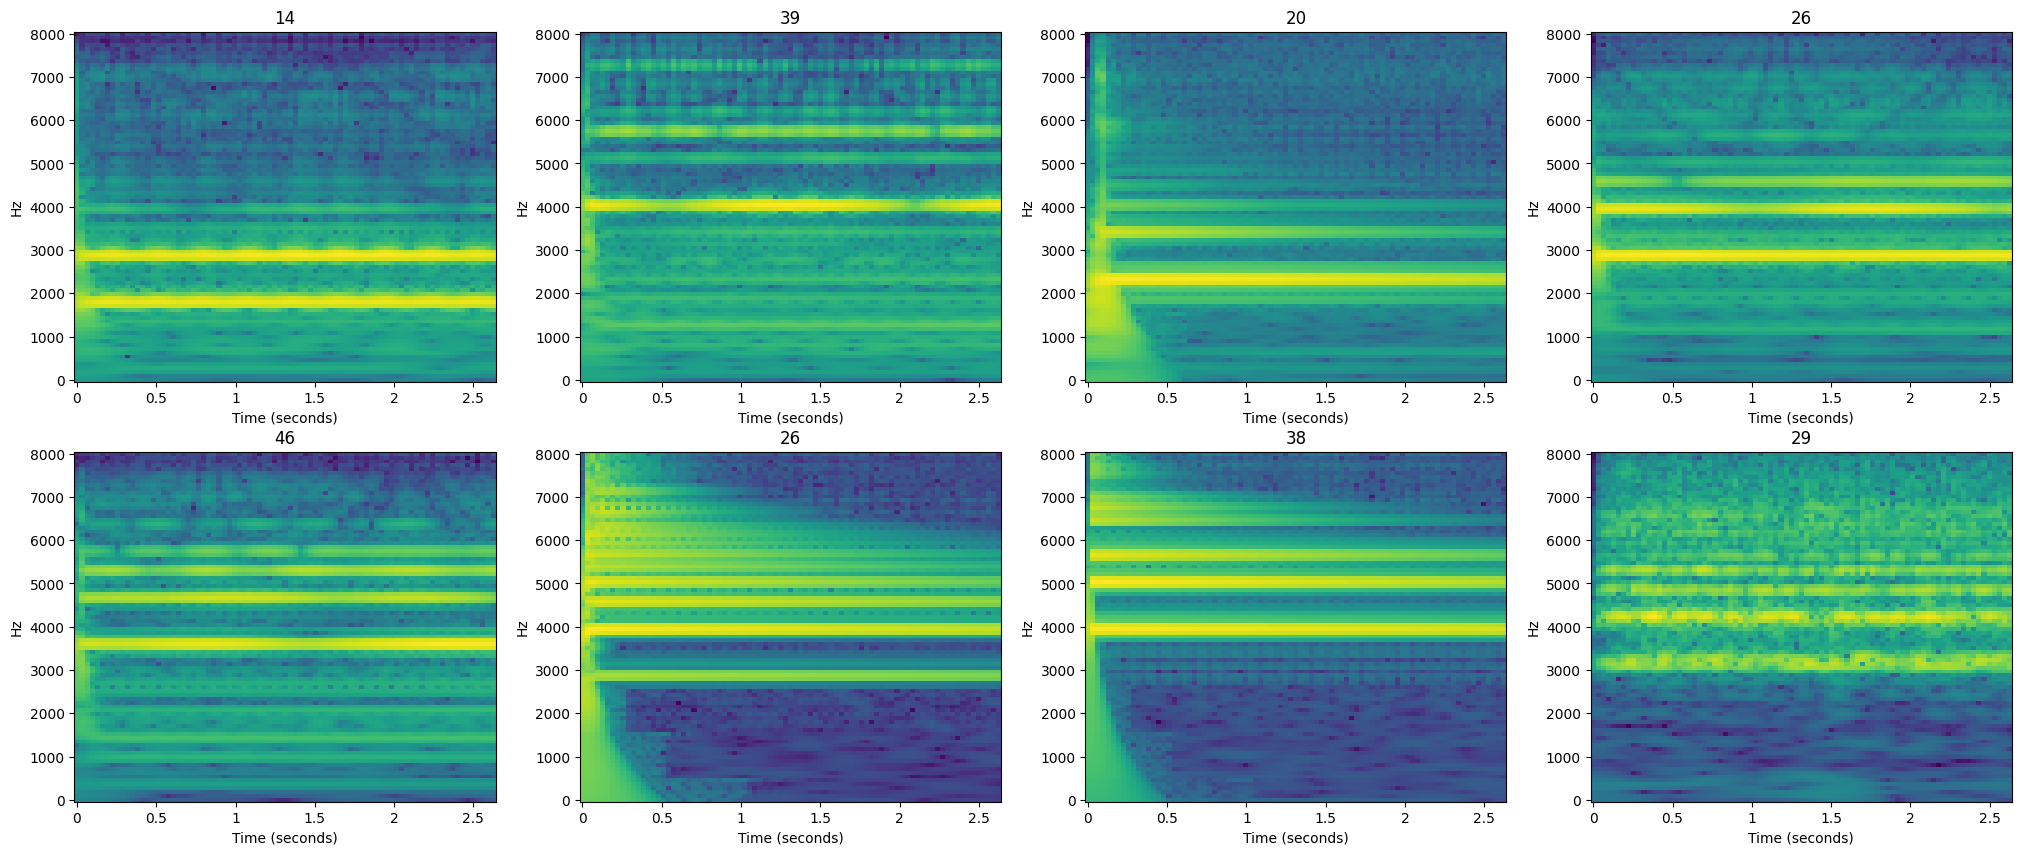

In [ ]:
drawSpec(validationData, validationLabel)

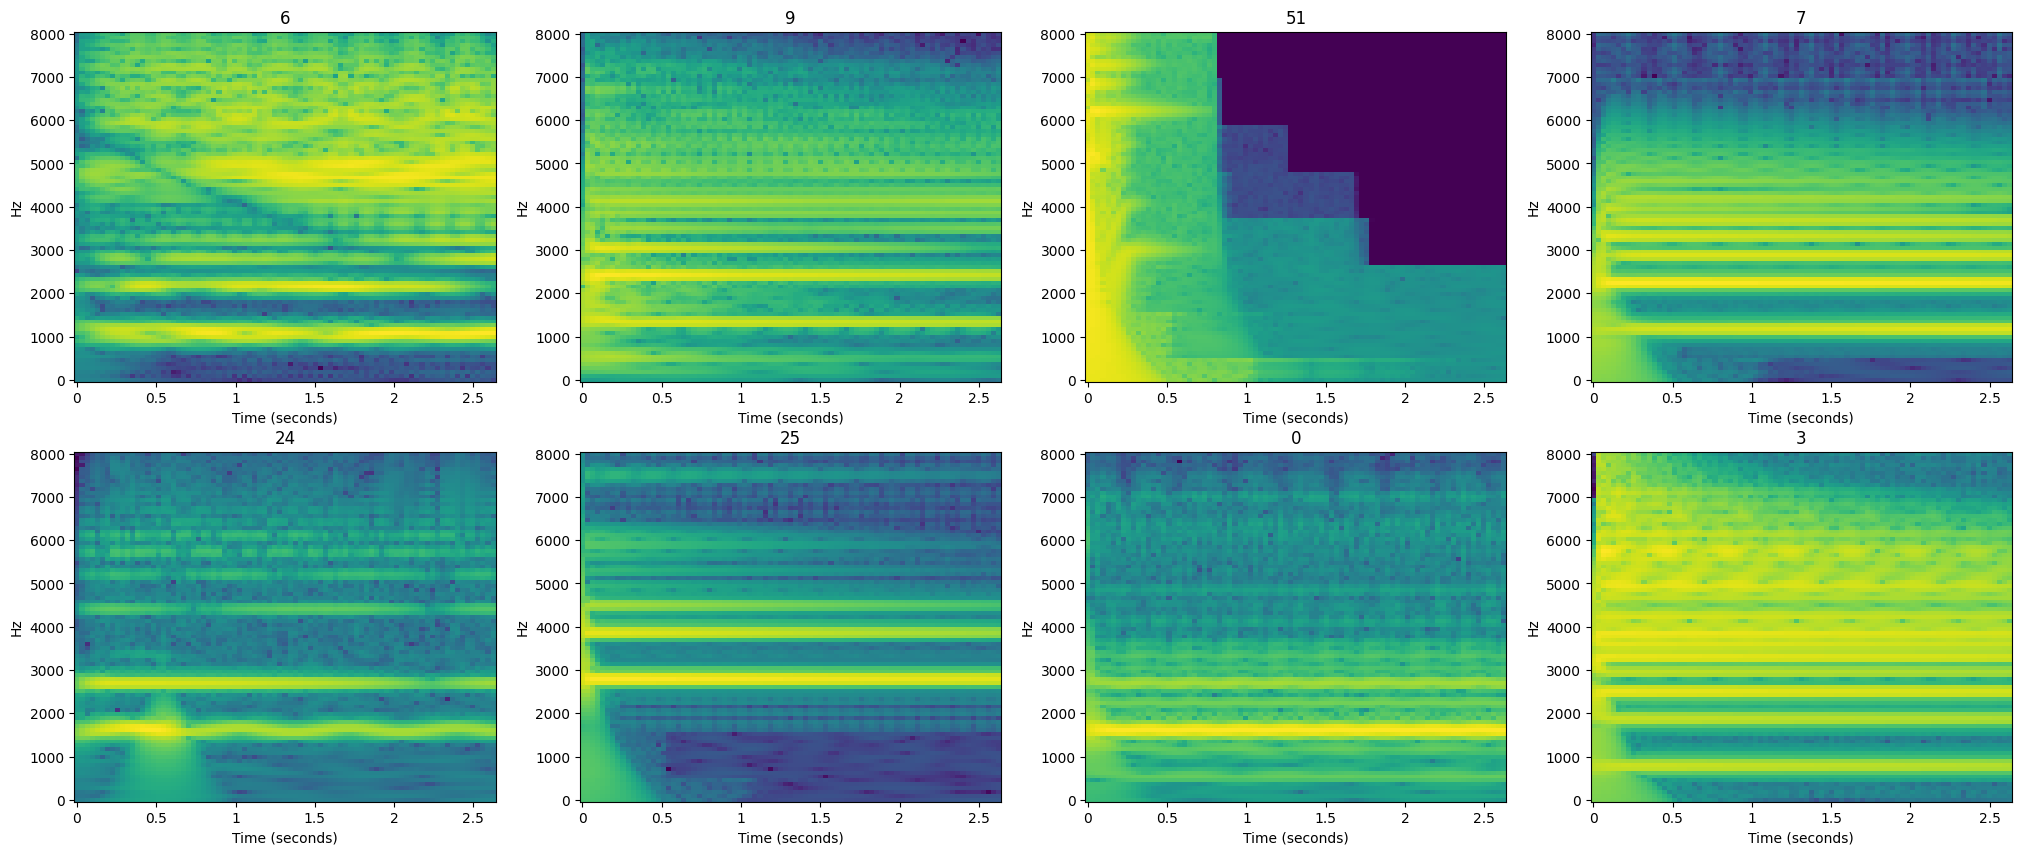

In [ ]:
drawSpec(testData, testLabel)

In [ ]:
from google.colab import drive
import numpy as np
drive.mount('/content/gdrive')

testData=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testData16_71Class_cqt.npy')
testLabel=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testLabel16_71Class_cqt.npy')
validationData=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/validationData16_71Class_cqt.npy')
validationLabel=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/validationLabel16_71Class_cqt.npy')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf

class CustomAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,  activation=None):
        super(CustomAttentionLayer, self).__init__()
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):

        self.input_dim = input_shape[-1]
        self.w = self.add_weight(
            shape=(self.input_dim,1),
            initializer="random_normal",
            trainable=True,
        )
        

    def call(self, inputs):        
        
        alphaVector = tf.reshape(self.activation(self.w), shape=[32,])
        # attentionVector = tf.keras.layers.Softmax(axis=0)(alphaVector)
        
        #output = inputs*attentionVector
        
        return alphaVector

input_tensor = tf.keras.layers.Input(shape=(7,6,32), batch_size=None)
layer = CustomAttentionLayer(activation='tanh')(input_tensor)
layer.shape

TensorShape([32])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, Resizing, BatchNormalization, Activation, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

def buildModel(inputAudio):

  layer1 = Conv2D(32, 3, activation='relu')(inputAudio)  
  layerb = BatchNormalization()(layer1)
  layer2 = MaxPooling2D()(layerb)
  layerd = Dropout(0.25)(layer2)
  layer3 = Conv2D(32, 3, activation='relu')(layerd)  
  layer4 = MaxPooling2D()(layer3)
  layerd1 = Dropout(0.25)(layer4)
  layer5 = Conv2D(32, 3, activation='relu')(layerd1)
  layer6 = MaxPooling2D()(layer5)  
  layerd2 = Dropout(0.25)(layer6)
  layer7 = Conv2D(32, 3, activation='relu')(layerd2)

  attention2D = Conv2D(32, 3, activation=None, padding = 'same')(layer7)
  attentionMap = tf.keras.layers.Softmax()(attention2D)
  multiplyLayer = tf.keras.layers.Multiply()([layer7, attentionMap])

  # alphaLayer = CustomAttentionLayer(activation='tanh')(layer7)
  # attentionLayer = tf.keras.layers.Softmax()(alphaLayer)
  # multiplyLayer = layer7*attentionLayer

  #layer8 = MaxPooling2D()(layer7)  
  layer9 = Dropout(0.25)(multiplyLayer)   
  layer10 = Flatten()(layer9)
  layer11 = Dense(512, activation='relu')(layer10)
  layerd3 = Dropout(0.25)(layer11)  
  layer13 = Dense(128, activation='relu')(layerd3)   
  layerd4 = Dropout(0.25)(layer13)  
  layer14 = Dense(71, activation='softmax')(layerd4) 

  return layer14

numOfRow=90
numOfColumn=83
inputSignal = Input(shape=(numOfRow, numOfColumn, 1))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 83, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 88, 81, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 88, 81, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 44, 40, 32)   0           ['batch_normalization[0][0]']

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_cqt_attention_Conv2D.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

batch_size=32
epochs=30

hist=model.fit( validationData,
                validationLabel,
                epochs=epochs,
                shuffle=True,
                batch_size=batch_size,
                verbose=2,
                validation_split=0.15,
                callbacks=callbacks_list)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.79123, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_cqt_attention_Conv2D.h5
287/287 - 18s - loss: 2.2237 - accuracy: 0.4240 - val_loss: 1.7926 - val_accuracy: 0.7912 - 18s/epoch - 62ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.79123 to 0.90303, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_cqt_attention_Conv2D.h5
287/287 - 3s - loss: 0.7029 - accuracy: 0.8231 - val_loss: 0.4823 - val_accuracy: 0.9030 - 3s/epoch - 12ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.90303 to 0.92773, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_cqt_attention_Conv2D.h5
287/287 - 3s - loss: 0.4842 - accuracy: 0.8781 - val_loss: 0.3884 - val_accuracy: 0.9277 - 3s/epoch - 12ms/step
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.92773
287/287 - 4s - loss: 0.

#NSynth - NSynth

In [ ]:
filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_cqt_attention_Conv2D.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(32)
result = predModel.evaluate(test_dataset)

110/110 [==============================] - 1s 7ms/step - loss: 0.1011 - accuracy: 0.9782


#NSynth - TinySOL

In [ ]:
import numpy as np
from google.colab import drive
#drive.mount('/content/gdrive')

testData=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/trainData16_71Class_cqt.npy')
testLabel=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/trainLabel16_71Class_cqt.npy')

filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_cqt_attention_Conv2D.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(32)
result = predModel.evaluate(test_dataset)

90/90 [==============================] - 1s 6ms/step - loss: 0.0395 - accuracy: 0.9937


#TinySOL - NSynth

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

testData=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testData16_71Class_cqt.npy')
testLabel=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testLabel16_71Class_cqt.npy')

filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_TinySOL_71Class_cqt_attention_Conv2D.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(32)
result = predModel.evaluate(test_dataset)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
110/110 [==============================] - 1s 4ms/step - loss: 2.2830 - accuracy: 0.8743
